# <span style="color:blue">Проект по А/B-тестированию к выпускному проекту</span> 

<span style="color:green">**ОПИСАНИЕ ПРОЕКТА**</span> 

В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

**Цель:**: Дать оценку проведения A/B теста:
- Оценить корректность проведения теста
- Проанализировать результаты теста

Чтобы оценить корректность проведения теста, необходимо проверить:
- что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно
- равномерность распределения пользователей по тестовым группам и правильность их формирования

1. **Загрузка и обработка данных:**
- 1.1 Обработка и  преобразование типов данных
- 1.2 Обработка пропусков и дубликатов
2. **Оценка корректности проведения теста. Внимание на:**
- 2.1 Соответствие данных требованиям технического задания. 
- 2.2 Время проведения теста. Убедимся, что оно не совпадает с маркетинговыми и другими активностями.
- 2.3 Аудиторию теста. 
- Проверим, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно.
- Проверим равномерность распределения пользователей по тестовым группам и правильность их формирования.
3. **Исследовательский анализ данных.** Определить:
- 3.1 Каково распределение количества событий на пользователя в выборках
- 3.2 Как число событий в выборках распределено по дням
- 3.3 Как меняется конверсия в воронке в выборках на разных этапах
- 3.4 Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?
4. **Проведение оценки результатов A/B-тестирования:**
- 4.1 Общее заключение по результатам A/B-тестирования
- 4.2 Проверка статистической разницы долей z-критерием
5. **Общие выводы** по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования. 

<span style="color:green">**Техническое задание**</span> 
- **Название теста:** recommender_system_test;
- **Группы: А** (контрольная), **B** (новая платёжная воронка);
- **Дата запуска:** 2020-12-07;
- **Дата остановки** набора **новых** пользователей: 2020-12-21;
- **Дата остановки:** 2021-01-04;
- **Аудитория:** 15% новых пользователей из региона EU;
- **Назначение теста:** тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемое **количество участников** теста: 6000.
- **Ожидаемый эффект:** за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
- **конверсии в просмотр** карточек товаров — событие product_page
- **просмотры корзины** — product_cart
- **покупки** — purchase.

Необходимо загрузить данные теста, проверить корректность его проведения и проанализировать полученные результаты.

<span style="color:green">**Описание данных**</span> 

- **ab_project_marketing_events.csv** — календарь маркетинговых событий на 2020 год
  - **name** — название маркетингового события;
  - **regions** — регионы, в которых будет проводиться рекламная кампания;
  - **start_dt** — дата начала кампании;
  - **finish_dt** — дата завершения кампании.
  
- **final_ab_new_users.csv** — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года
  - **user_id** — идентификатор пользователя;
  - **first_date** — дата регистрации;
  - **region** — регион пользователя;
  - **device** — устройство, с которого происходила регистрация.
  
- **final_ab_events.csv** — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года
  - **user_id** — идентификатор пользователя;
  - **event_dt** — дата и время события;
  - **event_name** — тип события;
  - **details** — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.
  
- **final_ab_participants.csv** — таблица участников тестов
  - **user_id** — идентификатор пользователя;
  - **ab_test** — название теста;
  - **group** — группа пользователя.

### Загрузка и предобработка данных

In [1]:
# импортируем все нужные для работы библиотеки
import pandas as pd
import numpy as np

import math as mth
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import plotly.express as px
from plotly import graph_objects as go

from scipy import stats as st

import warnings
warnings.simplefilter(action= 'ignore', category= FutureWarning)

In [2]:
# настроим изображение таблиц так, чтобы все столбцвы были всегда видны
pd.set_option('display.max_columns', None)

#и установим ширину ячеек
pd.set_option("max_colwidth", 999)

In [3]:
# пропишем пути к датасэтам
marketing_events= pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
new_users= pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
events= pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
participants= pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')

In [4]:
# Напишем функцию вывода основных данных по датасетам и пропустим через цикл
for df in [marketing_events, new_users, events, participants]:
    print()
    display(df.info())
    display(df.head())
    print()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<span style="color:brown">**1.1 Обработка и преобразование типов данных**</span>
- Названия колонок всех таблиц соотвествуют стилю "snake case"
- Данные в столбцах с датой и временем необходимо привести к корректному типу:
  - в таблице **marketing_events** столбцы **'start_dt' и 'finish_dt'**
  - в таблице **new_users** столбец **'first_date'**
  - в таблице **events** столбец **'event_dt'**
- В таблице **marketing_events** столбец с регионами называется **regions**, а в таблице **new_users - region**.

In [5]:
# приведем данные к корректному типу данных в столбцах с датой и временем
marketing_events['start_dt']= pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt']= pd.to_datetime(marketing_events['start_dt'])
new_users['first_date']= pd.to_datetime(new_users['first_date'])
events['event_dt']= pd.to_datetime(events['event_dt'], format= '%Y-%m-%d %H:%M:%S')

In [6]:
# проверим
for df in [marketing_events, new_users, events]:
    print()
    display(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


None

**Итак,** теперь все типы данных корректны. Осталось проработать пропуски и дубликаты

<span style="color:brown">**1.2 Обработка пропусков и дубликатов**</span>

In [7]:
# Напишем функцию вывода основных данных по датасетам и пропустим через цикл
for df in [marketing_events, new_users, events, participants]:
    print('-'*50)
    print('\n Найдено дубликатов в датасете: {}\n'.format(df.duplicated().sum()), 
          "Количество пропущенных значений: {} строк".format(df.isnull().sum().sum())) 

--------------------------------------------------

 Найдено дубликатов в датасете: 0
 Количество пропущенных значений: 0 строк
--------------------------------------------------

 Найдено дубликатов в датасете: 0
 Количество пропущенных значений: 0 строк
--------------------------------------------------

 Найдено дубликатов в датасете: 0
 Количество пропущенных значений: 377577 строк
--------------------------------------------------

 Найдено дубликатов в датасете: 0
 Количество пропущенных значений: 0 строк


**Итак,** дубликатов нет ни в одной таблице. Пропуски только в датасэте **events**, посмотрим, каких данных не хватает


In [8]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


**Итак,** Пропуски в столбце **details**, в котором хранятся дополнительные данные о событии. Например, для покупок, **purchase**, в этом поле хранится стоимость покупки в долларах.

In [9]:
# посмотрим на типы событий в столбце 'event_name', так мы сможем понять есть ли связь типа purchase и пропусков
events['event_name'].value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

**Итак,** Мы видим полное соответствие количества пропусков и количества событий без учета покупки **purchase**
- 377577(количество пропусков)= 189552+ 125563+ 62462

Оставляем пропуски как есть, ничего менять не нужно, данные отсутствуют потому что, не было дополнительной информации о событии

### Оценка корректности проведения теста 

<span style="color:brown">2.1 Соответствие данных требованиям технического задания</span>

In [10]:
# посмотрим на таблицу с данными участников тестов
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


**Итак,** 
- Название теста: **recommender_system_test** - корректное, информация по участникам этого теста есть
- Группы: **А** — контрольная, **B** — новая платёжная воронка. Других групп нет в тесте

<span style="color:brown">2.2 Время проведения теста. Убедимся, что оно не совпадает с маркетинговыми и другими активностями</span>

In [11]:
# посмотрим календарь маркетинговых событий на 2020 год в порядке времени их проведения  
marketing_events.sort_values(by= 'start_dt', ascending= True)

,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-01-25
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-14
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-08
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-17
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-12
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-01
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-09
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-06-25
4,4th of July Promo,N.America,2020-07-04,2020-07-04
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-01


Согласно **условию ТЗ** период исследования: **с 07.12.2020 по 04.01.2021** года, поэтому проверим наличие маркетинговых мероприятий именнов этот временной промежуток

In [12]:
# создадим новую таблицу пл интересующему временному диапазону
marketing_events_new= marketing_events[(marketing_events['start_dt'] <= "2021-01-04") & 
                                          (marketing_events['finish_dt'] >= "2020-12-07")]
marketing_events_new

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2020-12-25
10,CIS New Year Gift Lottery,CIS,2020-12-30,2020-12-30


**Итак,** согласно условию ТЗ дата отановки должна быть 04.01.2021, но эксперимент закончился на 4 дня раньше, 30.12.2020.

In [13]:
print(f"Период наблюдения: {events['event_dt'].max()- events['event_dt'].min()}")

Период наблюдения: 23 days 23:36:00


**Вывод:** В период исследования проводилось две однодневных маркетинговых акции:

- Первая: 25.12.20 в Европе и Северной Америке
- Вторая: 30.12.20 в СНГ

Эти акции прововдились в канун Рождества и Нового года, поэтому точно окажут влияние на поведение клиентов в это период с пролонгированым действием на начало следующего года.

<span style="color:brown">2.3 Аудитория теста</span>

- Проверим, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно.
- Проверим равномерность распределения пользователей по тестовым группам и правильность их формирования.

In [14]:
# посмотрим сколько всего было тестов и участников
participants.groupby('ab_test').nunique()

,user_id,group
ab_test,,
interface_eu_test,11567,2
recommender_system_test,6701,2


**Итак,** проводилось 2 теста. Мы располагаем данными только по тесту **recommender_system_test**, про второй нам ничего не известно. По названию, можно предположить, что участвовал регион EU и, предположительно, связан с тестированием какого-то интерфейса.

In [15]:
# количество пользователей, которые состоят в одной или двух группах
participants.groupby('user_id').agg({'ab_test':'nunique'}).value_counts()

ab_test
1          15064
2           1602
dtype: int64

**Итак,** 
- 1602 уникальных пользователя приняли участие сразу в 2-ух тестах. Логично, что "двойников" нужно было бы исключить. 
- **НО!!!** нам неизвестно, в какие даты проходили эти тесты, возможно, и в разные, то есть не одновременно с нашим. 
- Допустим, что даже если и в одно время с нашим тестом, значит под него попали обе наши тестовые выборки, следовательно, влияние на ход экспериментов был равнозначным. 
- Поэтому, **удалять** этих пользователей мы **не будем**. 
- Оставим данные только для нашего теста, исключим участников второго теста

In [16]:
# сформируем новую таблицу с recommender_system_test
participants_new= participants.loc[participants['ab_test'] == "recommender_system_test"]
participants_new

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
6696,053FB26D6D49EDDC,A,recommender_system_test
6697,9D263B8EF15CF188,B,recommender_system_test
6698,F2FBBA33F37DEC46,A,recommender_system_test
6699,29C92313A98B1176,B,recommender_system_test


<font color='4682B4'> Петр, хороший комментарий! Я согласна, расскажу почему я всё-таки пошла по этому пути!

Изначально, в первой итерации, я удалила этих пользователей, процент небольшой и я не стала сомневаться. Но вот дальше получились цифры, которые меня заставили посомневаться.🤔
Во-первых, участников, действительно, стало меньше, чуть более 5000 (точную цифру не помню), и процент из EU тоже получился около 12, вместо заявленных 15. 

Я рассудила следующим образом: "Ну, ОК. Лучше меньше, да лучше" (качественее выборка). А вот когда я дошла до воронки и посмотрела на результаты гипотезы, мне не понравилось, что на всех этапах гипотеза была отвергнута. И результат теста оказался провальным. Поэтому стала думать, и пришла к такому выводу:
    
Обычная математика: если взять, например число 2 от 5, то это 40%, а если 2 от 10-ти, то это 20%. 
Так как я удалила этих Дублёров, соотношение в воронке сразу стало статистически значимым на каждом шаге.
И я подумала о том, что может пойти по другому пути - не удалять по причинам, указанным выше в комментарии. Оказалось, что результат теста такой же, но воронка изменилась. Статистически значимой оказалась разница только на этапе перехода на экран продукта. И приняла решение оставить этот вариант, он показался мне более интересным в плане анализа)
Вот так я прошла 2 итерации проекта.

</font>

**Итак,** одно из условий ТЗ - Ожидаемое количество участников теста: 6000. У нас их больше, то есть и это условие корректно.

In [17]:
# посмотрим на таблицу с пользователями, зарегистрировавшимися в ИМ в период с 7 по 21 декабря 2020 года
new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Теперь нам нужно привести в соответствие данные, объединив таблицы по пользователям

In [18]:
# объединим таблицы participants_new и new_users_correct по столбцу user_id
participants_users= pd.merge(participants_new, new_users, on = 'user_id')
participants_users.head()

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC


Проверим следующее условие ТЗ - Аудитория: 15% новых пользователей из региона EU. Для это посмотрим откуда, из какого региона участники нашего эксперимента

In [19]:
# количество пользователей в разных регионах 
participants_users[participants_users['user_id'].isin(participants['user_id'])]['region'].value_counts()

EU           6351
N.America     223
APAC           72
CIS            55
Name: region, dtype: int64

**Итак,** 
- В тесте участвуют люди не только их региона EU. Исключим этих пользователей, чтобы тест соответствовал ТЗ. 
- Останется 6351 пользователь из региона **EU** .

In [20]:
# пользователи из региона EU
eu_users= new_users.query('region == "EU"')

In [21]:
# доля пользователей, участвующих в тесте
print('Количество пользователей из региона EU:', len(participants_users.query('region == "EU"')))
print('Доля новых пользователей из региона EU:', round(((participants_users['user_id'].count()/ eu_users['user_id'].count())*100),1), '%')

Количество пользователей из региона EU: 6351
Доля новых пользователей из региона EU: 14.5 %


**Итак,** с этим требованием ТЗ тоже всё в порядке, почти **15%** (0,5% погрешность ) новых пользователей **из региона EU**

In [22]:
# посмотрим на период данных нашего теста, соответствует ли и он ТЗ
print(f"Даты прведения эксперимента: {participants_users['first_date'].min()} по {participants_users['first_date'].max()}")
print(f"Временной промежуток эксперимента: {participants_users['first_date'].max() - participants_users['first_date'].min()}")

Даты прведения эксперимента: 2020-12-07 00:00:00 по 2020-12-21 00:00:00
Временной промежуток эксперимента: 14 days 00:00:00


In [23]:
# посмотрим на распределение участников групп эксперимента
participants_group = participants_users.groupby('group') \
.agg({'user_id': 'nunique'}).reset_index()
participants_group.columns = ['test_group', 'users']
participants_group['%_of_all_users'] = (participants_group['users']/participants_group['users'].sum()).round(2)
participants_group

,test_group,users,%_of_all_users
0,A,3824,0.57
1,B,2877,0.43


**Итак,** распределение по группам неравномерное, разница почти в 20%.

**Вывод:**
- Мы проверили данные на соответствие ТЗ и выяснили, что:
- **Соответствует ТЗ**
1. Название теста: recommender_system_test 
2. Группы: А — контрольная, B — новая платёжная воронка. Других групп нет в тесте 
3. Дата запуска: 2020-12-07 
4. Дата остановки набора новых пользователей: 2020-12-21 
5. Доля новых пользователей из региона EU без погрешности в 0,5% составляет 15%
6. В эксперименте принимают участие 6701 пользователей при ожидаемых 6000 

- **Не соответствует ТЗ**
1. Дата остановки: 2021-01-04. Тест остановлен 30 Декабря 2020, данные за оставшиеся 5 дней не собирались или были утеряны.
2. Есть пользователи - "двойники", 1602 посетителя участвовали сразу в 2-ух тестовых группах
9. Распределение участников по тестовым группам неравномерное. В контрольной группе "А" 57% пользователей, в группе "В" соотвественно, 43%.  

Можно приступать к исследованию

### Исследовательский анализ данных

<span style="color:brown">3.1 Каково распределение количества событий на пользователя в выборках</span>

In [24]:
# нас интресует таблица с данными о событиях events
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [25]:
# есть ранее сформированная нами таблица participants_users
participants_users.head(3)

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac


В таблице есть:
- дата регистрации
- девайс(устройство, с которого прошла регистрация пользователя).
- По этим ддвум метрикам можно посмотреть распределение участников, есть ли какая-то зависимость/зокномерность

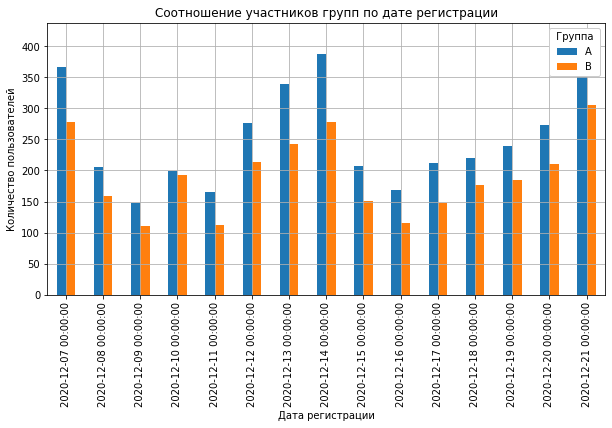

In [26]:
# распределение участников по дате регистрации
participants_users.pivot_table(index='first_date', 
                     columns='group', 
                     values='user_id', 
                     aggfunc='nunique').plot(kind='bar', figsize=(10, 5))
plt.grid()
plt.xticks(rotation=90)
plt.title('Соотношение участников групп по дате регистрации')
plt.xlabel('Дата регистрации')
plt.ylabel('Количество пользователей')
plt.legend(title=' Группа ', framealpha= 1)
plt.show()

Из графика видно, что относительная разница **между группами А и В** приблизительно одинакова. Исключение только 10 декабря,  пользователей из группы "В" в этот день зарегистрировалось больше.

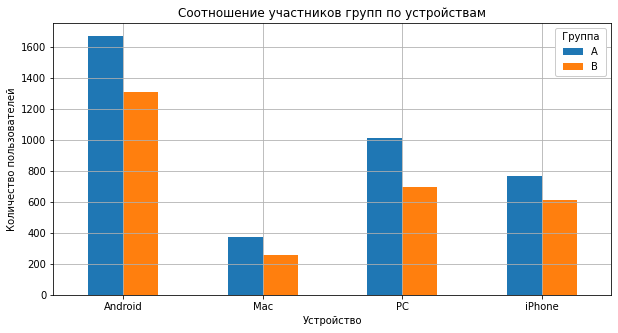

In [27]:
# посмотрим на распределение участников по устройствам
participants_users.pivot_table(index='device', 
                     columns='group', 
                     values='user_id', 
                     aggfunc='nunique').plot(kind='bar', figsize=(10, 5))
plt.grid()
plt.xticks(rotation=0)
plt.title('Соотношение участников групп по устройствам')
plt.xlabel('Устройство')
plt.ylabel('Количество пользователей')
plt.legend(title=' Группа ', framealpha= 1)
plt.show()

Относительная разницу между группами также приблизительно одинакова между пользователями разных **устройств**.

Эта информация гоаорит о том, что группы,хоть и различны, по количеству участников, но соотношение между группами по эти двум метрикам равнозначное. На дальнейший ход исследования эти метрики не повлияют, но проверить было интересно!!!

Далее посмотрим на рспрелделение событий по дням и пользователям.

<span style="color:brown">3.2 Как число событий в выборках распределено по дням</span>

Теперь нужно соотнести сбытия с пользователями, объединим эти 2 таблицы снова по **user_id** и посмотрим распределение количества событий по дням

In [28]:
# объединяем participants_users и events(данные о всех событиях)
participants_users_events = pd.merge(participants_users, events, on = 'user_id', how='left')
participants_users_events.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,NaN
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN


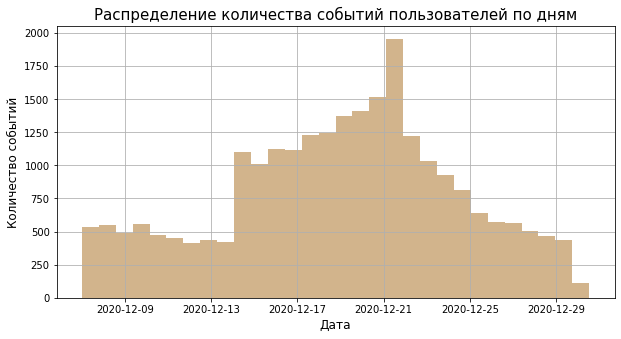

In [29]:
# визуализируем, построим график количества всех событий всех пользователей по дням
plt.figure(figsize= (10, 5))
plt.hist(participants_users_events['event_dt'], color='tan', bins = 30)
plt.xlabel('Дата', fontsize= 12)
plt.ylabel('Количество событий', fontsize=12)
plt.title('Распределение количества событий пользователей по дням', fontsize= 15)
plt.grid()
plt.show()

**Итак,** 
- Из графика видно, что "старт" начался ориентировочно с 550 пользователей 
- **14-12-2020** резкий всплеск активности
- "пик" приходится на дату **22-12-2020**
- и в конце эксперимента(ориентирв) резкое "падение" значений

Посмотрим сколько записей в последний день наблюдения **30-12-2020**

In [30]:
participants_users_events.query('event_dt >= "2020-12-30"')

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
4391,75845C83258FBF73,B,recommender_system_test,2020-12-07,EU,Android,2020-12-30 06:42:52,product_cart,NaN
4395,75845C83258FBF73,B,recommender_system_test,2020-12-07,EU,Android,2020-12-30 06:42:52,login,NaN
25493,DD4352CDCF8C3D57,B,recommender_system_test,2020-12-07,EU,Android,2020-12-30 12:42:57,product_page,NaN
25499,DD4352CDCF8C3D57,B,recommender_system_test,2020-12-07,EU,Android,2020-12-30 12:42:56,login,NaN


Как мы и предполагали: **30-12-2020 всего 4 события**, что делает результаты сравнения с другими днями нерелевантными. Удалим их.

In [31]:
# перезапишем датасет исключив аномальную дату
participants_users_events = participants_users_events.query('event_dt < "2020-12-30"')

In [32]:
# количество событий на пользователя
events_by_users = participants_users_events.groupby(['user_id','group'])['event_name'].count().reset_index()
events_by_users.sort_values(by='event_name', ascending=False)

,user_id,group,event_name
233,1198061F6AF34B7B,B,28
229,115EBC1CA027854A,B,27
404,1BFEE479308EFF44,A,24
2984,CED71698585A2E46,A,24
2660,B8EF6F0325A9979F,A,21
...,...,...,...
3614,FC2DA0D7EF375B27,B,1
3481,F26444BA1B35C213,B,1
2977,CE48F47093B03425,A,1
2848,C5C355D72A66F9FB,A,1


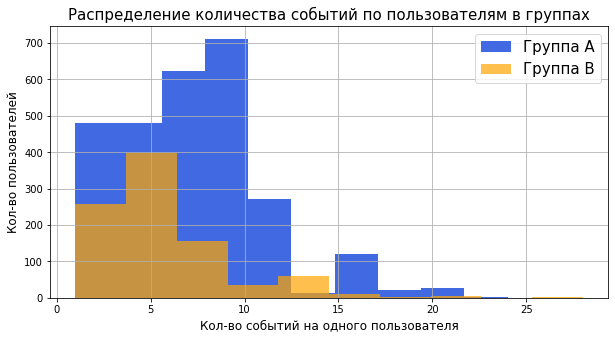

In [33]:
# построим график распределения количества событий по пользователям
plt.figure(figsize=(10, 5))
plt.hist(events_by_users.query('group == "A"')['event_name'], label='Группа A', color='royalblue')
plt.hist(events_by_users.query('group == "B"')['event_name'], label='Группа B', alpha= 0.7, color='orange')
plt.xlabel('Кол-во событий на одного пользователя', fontsize= 12)
plt.ylabel('Кол-во пользователей', fontsize= 12)
plt.title('Распределение количества событий по пользователям в группах', fontsize= 15)
plt.legend(loc= 'best', fontsize= 15)
plt.grid()
plt.show()

Пользователи контрольной группы "А" оказались более активными в сравнении с пользователями группы "В"

Посмотрим как вели себя пользователи тестовых групп в **разбивке по дням**

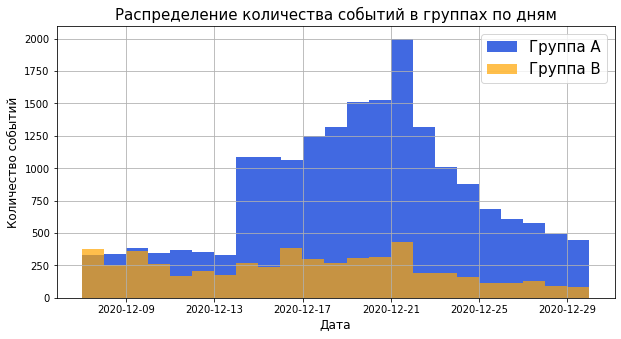

In [34]:
# построим график распределения количества событий в группах по дням
plt.figure(figsize= (10, 5))
plt.hist(participants_users_events.query('group == "A"')['event_dt'], label= 'Группа A', color= 'royalblue', bins= 23)
plt.hist(participants_users_events.query('group == "B"')['event_dt'], label= 'Группа B', alpha= 0.7, color= 'orange', bins= 23)
plt.xlabel('Дата', fontsize= 12)
plt.ylabel('Количество событий', fontsize= 12)
plt.title('Распределение количества событий в группах по дням', fontsize=15)
plt.legend(loc= 'best', fontsize= 15)
plt.grid()
plt.show()

In [42]:
users_A= participants_users_events.query('group == "A"')
users_B= participants_users_events.query('group == "B"')
print('В среднем пользователь совершает {:.0f} действий'.format(participants_users_events.groupby('user_id')['event_name'].count().mean()))
print('В среднем пользователь группы "А" совершает {:.0f} действий'.format(users_A.groupby('user_id')['event_name'].count().mean()))
print('В среднем пользователь группы "В" совершает {:.0f} действий'.format(users_B.groupby('user_id')['event_name'].count().mean()))


В среднем пользователь совершает 7 действий
В среднем пользователь группы "А" совершает 7 действий
В среднем пользователь группы "В" совершает 6 действий


**Итак,** 
- Пользователи контрольной группы "А" оказались в среднем совершают на 1 действие больше.
- Участники группы "В" ведут себя "спокойно", без всплесков и провалов на протяжении всего экперимента, особой активности пользователей не наблюдается.

<span style="color:brown">3.3 Как меняется конверсия в воронке в выборках на разных этапах</span>

In [43]:
# сформируем таблицу для построения воронки и посмотрим количество событий в разных группах
funnel= participants_users_events.groupby('group')['user_id'].nunique()
funnel

group
A    2747
B     928
Name: user_id, dtype: int64

Что мы видим:
- Число участников в контрольной и экспериментальной группах сильно отличается, разница почти в 70%, что ставит под сомнение результаты еще до проведения теста. Всопмним, что по условию ТЗ нам нужно не менее 6000 участников. посмотримм на конверсию каждого этапа в воронке

In [44]:
# создадим таблицу с количеством и долей пользователей из каждой группы с разбивкой по шагам воронки

df_test= (participants_users_events.pivot_table(
    index= 'event_name', 
    columns= 'group', 
    values= 'user_id',
    aggfunc= 'nunique')
    .sort_values(by= 'A', ascending= False)
    .reindex(['login', 'product_page', 'product_cart', 'purchase'])
    .reset_index(drop= False)
    )
df_test['share_A']= (df_test['A']/ funnel['A']* 100).round(1)
df_test['share_B']= (df_test['B']/ funnel['B']* 100).round(1)

df_test

group,event_name,A,B,share_A,share_B
0,login,2747,928,100.0,100.0
1,product_page,1780,523,64.8,56.4
2,product_cart,824,255,30.0,27.5
3,purchase,872,256,31.7,27.6


In [46]:
# визуализирум нашу воронку
fig= go.Figure()

fig.add_trace(go.Funnel(
    name= 'A',
    y= df_test['event_name'],
    x= df_test['A'],
    textinfo= "value+percent initial+percent previous",
    marker= {"color": "royalblue",
                "line": {"color": 'grey', "width": 1}}))


fig.add_trace(go.Funnel(
    name= 'B',
    y= df_test['event_name'],
    x= df_test['B'],
    textinfo= "value+percent initial+percent previous",
    marker= {"color": "orange",
                "line": {"color": 'grey', "width": 1}}))

fig.show()

**Вывод:** 
- Судя по воронке пользователи **группы "А"** конвертируются лучше с этапа скачивания приложения и на каждом последующем шаге. 
- **Группа "В"** конвертируется лучше только с момента просмотра карточки в просмотр корзины.

- Самая низкая конверсия на этапе **перехода на экран продукта**:
  - 65% в группе "А"
  - 56% в группе "В" 
  
- На этапе **Покупка** показатель конверсии:
  - 46% в группе "А"
  - 49% в группе "В" 

- а этапе **Положить в корзину** конверсия:
  - 106% в группе "А"
  - 100% в группе "В" 

- Такая **нетипичная картина** на последнем шаге возникла из-за того, что на сайте есть возможность оплатить покупку не заходя на страницу "Положить в корзину".

- До самого важного этапа "Покупка" в каждой группе дошла примерно треть пользователей:
  - 32% в группе "А"
  - 28% в группе "В"

<span style="color:brown">3.4 Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию</span>

1. Крайняя дата по событиям: **29-12-2020** (мы исключили дату 30-12-2020, как аномальную).
2. Как следствие, **14 дней** от крайней даты - это 15-12-2020. Следовательно, пользователи, которые залогинились с 16-12-2020 не будут удовлетворять условию ТЗ, так как не успеют "прожить" 2 недели.
3. Обнаружен всплеск активности контрольной **группы "А"** в период с 14-12-2020 с пиковыми значениями 22-12-2020 числа. С 23-12-2020 наблюдается спад активности, почти на 25% и плавным снижением до конца эсперимента.
4. В **группе "В"** подобного поведения не наблюдалось.
5. **Воронка** событий не типична.
6. Пользователи в группах **распределены неравномерно**, разница больше, чем вполовину, что не соответствует требованиям проведения А/B-тестов.
7. Количество участников меньше 6000, также не соответствует ТЗ.

По воронке можно увидеть различия в количестве событий авторизации и просмотра продуктовой корзины. Проверим гипотезу о равенстве долей с помощью z-test.

### Проведение оценки результатов A/B-тестирования

<span style="color:brown">4.1 Общее заключение по результатам A/B - тестирования</span>

Проведенный А/В тест можно назвать "провальным", так как основные условия ТЗ не были соблюдены:

- Дата остановки 2020-12-30 вместо 2021-01-04, при этом данные за 30.12.2020 неполные.
- Итоговое количество пучастников теста составило 3675, вместо ожидаемых 6000.
- Не был получен ожидаемый эффект: "за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%".
- Группа "В" показала результаты хуже, чем в группе "А"

<span style="color:brown">4.2 Проверка статистической разницы долей z-критерием</span>

In [47]:
# посмотрим на таблицу с количеством пользователей из каждой группы с разбивкой по шагам воронки
df_test

group,event_name,A,B,share_A,share_B
0,login,2747,928,100.0,100.0
1,product_page,1780,523,64.8,56.4
2,product_cart,824,255,30.0,27.5
3,purchase,872,256,31.7,27.6


In [50]:
# поправка Бонферрони 
alpha= .05/ 3

# функция проверки гипотезы на равенство долей 
def stat_difference(group1, group2, alpha_value):
    alpha= alpha_value
    event_name= df_test['event_name']
    
    for i in range(1,len(group1)):
        
        successes= np.array([group1[i], group2[i]])
        trials= np.array([group1[0], group2[0]])
       
        # пропорция успехов в 1 группе
        p1= successes[0]/ trials[0]  
        # пропорция успехов во 2 группе
        p2= successes[1]/ trials[1]  
        
        
        # пропорция успехов в комбинированном датасете
        p_combined= (successes[0]+ successes[1])/ (trials[0]+ trials[1]) 
        # разница пропорций в датасетах
        difference= p1 - p2  
        
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value= difference/ mth.sqrt(p_combined* (1 - p_combined)* (1/trials[0]+ 1/ trials[1]))
        
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr= st.norm(0, 1)  
        p_value= (1- distr.cdf(abs(z_value)))* 2
        
        # введем поправку Бонферрони, поделим альфа на число гипотез для всех проверок
        bonferroni_alpha= alpha/ 3
    
        print('Для события "{}" '.format(event_name[i]), end= '')
        print('(P-value =', p_value.round(3),'):')
        if (p_value< bonferroni_alpha):
            print('Отвергаем нулевую гипотезу о равенстве данных в группах')
        else:
            print('Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах') 
            
        print('')

In [51]:
stat_difference(df_test['A'], df_test['B'], 0.05/3)

Для события "product_page" (P-value = 0.0 ):
Отвергаем нулевую гипотезу о равенстве данных в группах

Для события "product_cart" (P-value = 0.145 ):
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах

Для события "purchase" (P-value = 0.018 ):
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах



**Итак,** статистически значимая разницы выявлена только для события "product_page" воронки продаж в группах "А" и "В". На остальных этапах воронки статразницы нет. Это было видно еще из самой воронки, но мы подтвердили это тестом.

### Общие выводы

**Общее заключение о корректности проведения теста**.

1. Мы проверили данные на **соответствие ТЗ** и выяснили, что:

- Название теста: recommender_system_test - **соответствует ТЗ**
- Группы: А — контрольная, B — новая платёжная воронка. Других групп нет в тесте - **соответствует ТЗ**
- Дата запуска: 2020-12-07 - **соответствует ТЗ**
- Дата остановки набора новых пользователей: 2020-12-21 - **соответствует ТЗ**
- Дата остановки: 2021-01-04 - **не соответствует ТЗ**. Тест остановлен 30 Декабря 2020, данные за оставшиеся 5 дней не собирались или были утеряны.
- Доля новых пользователей из региона EU без погрешности в 0,5% составляет 15%-  **соответствует ТЗ**
- В эксперименте принимают участие 6701 пользователей при ожидаемых 6000 - **соответствует ТЗ**
- 1602 пользователя участвовали сразу в 2-ух тестовых группах
- Распределение участников по тестовым группам неравномерное. В контрольной группе "А" 57% пользователей, в группе "В" соотвественно, 43%.  

2. Выводы по проведённой **оценке результатов A/B-тестирования**: Проведенный А/В тест можно назвать "провальным", так как основные условия ТЗ не были соблюдены:

- Дата остановки 2020-12-30 вместо 2021-01-04, при этом данные за 30.12.2020 неполные.
- Итоговое количество пучастников теста составило 3675, вместо ожидаемых 6000.
- Не был получен ожидаемый эффект: "за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%". Группа "В" показала результаты хуже, чем в группе "А"

3. Обнаружена **статистически значимая** разницы для события **"product_page"** воронки продаж в группах "А" и "В". Коэффициент конверсии группы "В" ниже, чем в контрольной группе "А" на 9%.

**Итог:** 
- Тест проводился на данных не соответствующих ТЗ, поэтому результаты нельзя считать достоверными. Мы можем только предполагать какие причины на это повлияли: либо корректность проведение самого теста, или же всё-таки изменения на сайте.

**Рекомендации:** провести А/В тест еще раз, но на условиях, которые удовлетворяют ТЗ.

- количество пользователей в двух группах должно разниться на 0.5-1%
- остановка теста должна произойти в согласованное время
- количество участников эксперимента должно быть не менее установленного
- в период проведения теста не должно быть никаких посторонних активностей